In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt

In [30]:
records_long = []
records_wide = []
n = 0
for line in open('f', 'r'):
    try:
        if line.startswith('b'): 
            cv = float(line.split(" ")[2])
        else:
            in_v, out_v = map(float, line.split(" "))
            records_long.append((n, 'cv', cv))
            records_long.append((n, 'in_v', in_v))
            records_long.append((n, 'out_v', out_v))
            records_wide.append((n, cv, in_v, out_v))
            n += 1
    except Exception as e:
        print(f"? [{line.strip()}] ({str(e)})")
df_long = pd.DataFrame(records_long, columns=['n', 'name', 'val'])
df_wide = pd.DataFrame(records_wide, columns=['n', 'cv', 'in_v', 'out_v'])

? [                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   14905] (could not convert string to float: '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

<Axes: xlabel='n', ylabel='cv'>

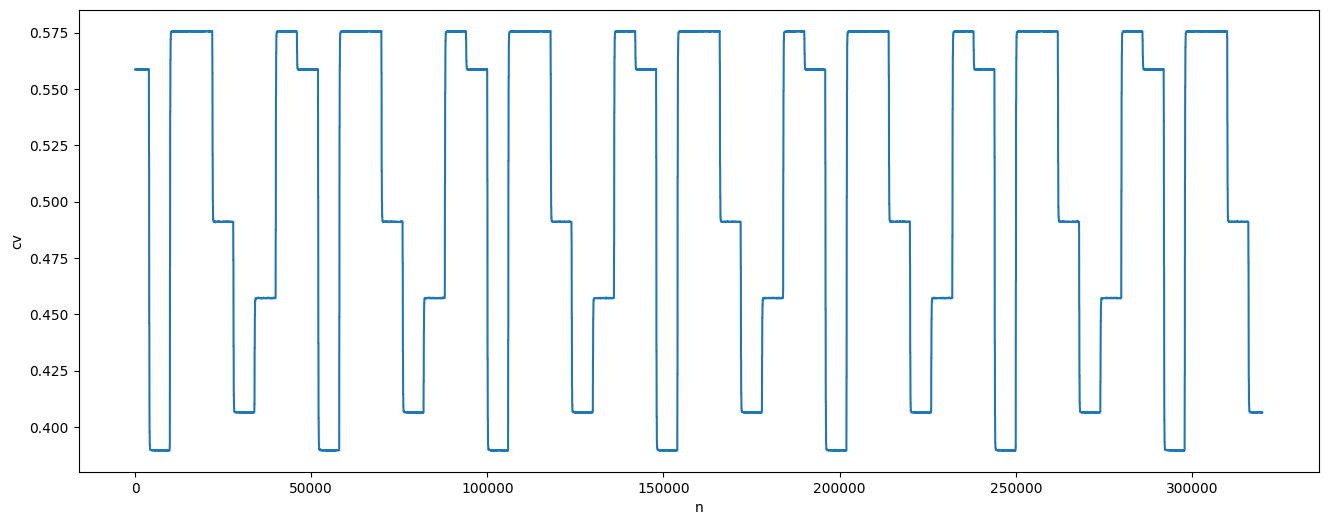

In [31]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_wide, x='n', y='cv')

/tmp/ipykernel_22224/2726709270.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df_long[11000:13000][df_long['name']=='cv'], x='n', y='val')


<Axes: xlabel='n', ylabel='val'>

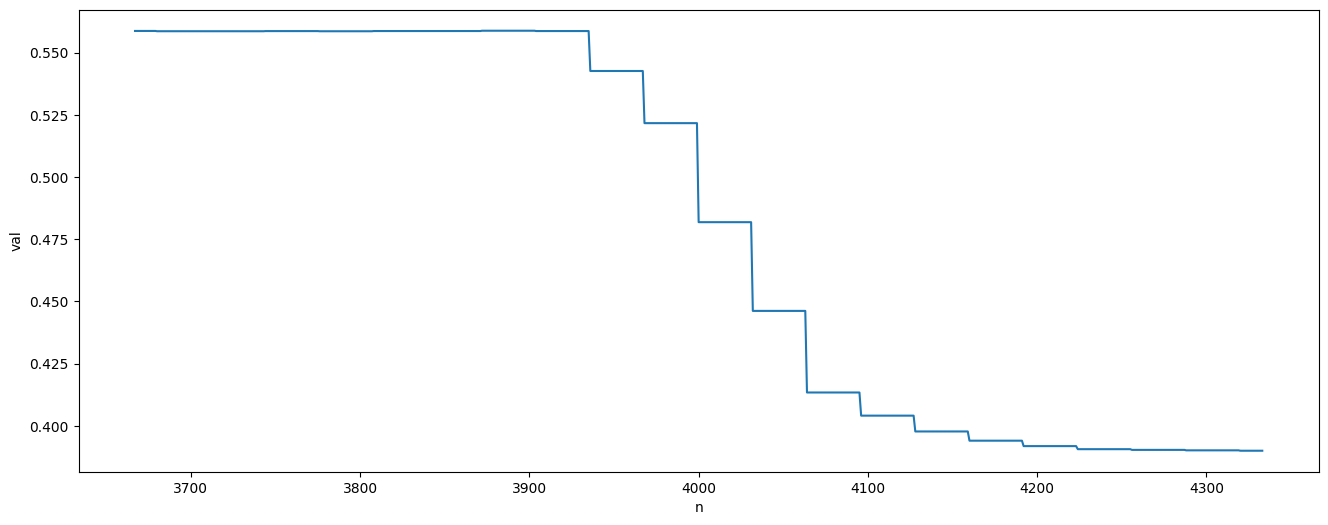

In [32]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_long[11000:13000][df_long['name']=='cv'], x='n', y='val')

<Axes: xlabel='n', ylabel='val'>

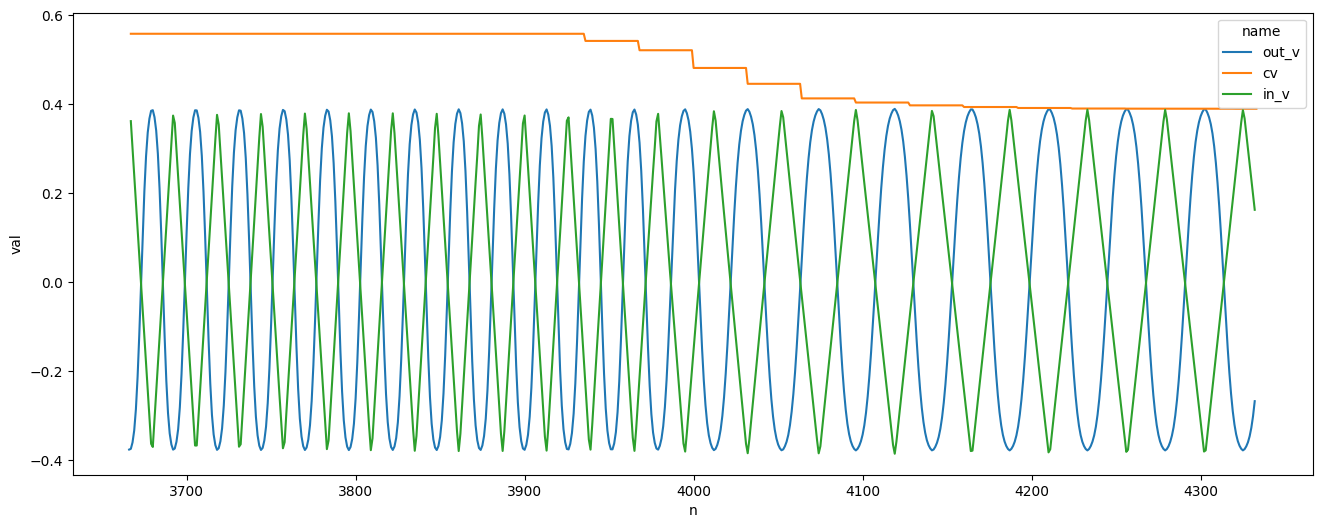

In [33]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_long[11000:13000], x='n', y='val', hue='name')

In [34]:
df_long.head()

,n,name,val
0,0,cv,0.558590
1,0,in_v,-0.317861
2,0,out_v,0.373839
3,1,cv,0.558590
4,1,in_v,-0.256649


In [35]:
df_wide.head()

,n,cv,in_v,out_v
0,0,0.55859,-0.317861,0.373839
1,1,0.55859,-0.256649,0.345888
2,2,0.55859,-0.193586,0.296658
3,3,0.55859,-0.131589,0.221585
4,4,0.55859,-0.069552,0.122621


In [36]:
cvs = np.array(df_wide['cv'])
in_vs = np.array(df_wide['in_v'])
x = np.stack([cvs, in_vs]).transpose()

y_true = np.expand_dims(np.array(df_wide['out_v']), -1)

split = int(len(x) * 0.95)

print(split, cvs.shape, in_vs.shape, x.shape)

303969 (319968,) (319968,) (319968, 2)


In [37]:
train_x, train_y = x[:split], y_true[:split]
test_x, test_y = x[split:], y_true[split:]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(303969, 2) (303969, 1) (15999, 2) (15999, 1)


In [38]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

TRAIN_SEQ_LEN = 20
TEST_SEQ_LEN = 9   # based on model


In [39]:
# for training and equiavlence testing

def create_dilated_model(seq_len, all_outputs=False):
    inp = Input((seq_len, 2))
    c1_output = Conv1D(name='c1', filters=4, kernel_size=3, dilation_rate=1, 
                       padding='causal', activation='relu', use_bias=False)(inp)
    c2_output = Conv1D(name='c2', filters=4, kernel_size=3, dilation_rate=3, 
                       padding='causal', use_bias=False)(c1_output)
    y_pred = Dense(name='d', units=1, activation=None)(c2_output)
    
    if all_outputs:
        model = Model(inp, [c1_output, c2_output, y_pred])
    else:
        model = Model(inp, y_pred)        
    print(model.summary())
    return model

# for testing ( i.e. getting only last of sequence )

def create_strided_model(seq_len, all_outputs=False):
    inp = Input((seq_len, 2))
    c1_output = Conv1D(name='c1', filters=4, kernel_size=3, strides=3, 
                       activation='relu', use_bias=False)(inp)
    c2_output = Conv1D(name='c2', filters=4, kernel_size=3, strides=3, 
                       use_bias=False)(c1_output)
    c2_output = Flatten()(c2_output)
    y_pred = Dense(name='d', units=1, activation=None)(c2_output)
    
    if all_outputs:
        model = Model(inp, [c1_output, c2_output, y_pred])
    else:
        model = Model(inp, y_pred)
    print(model.summary())
    return model

In [40]:
from tensorflow.keras.optimizers import Adam

train_model = create_dilated_model(TRAIN_SEQ_LEN, all_outputs=False)

opt = Adam(1e-4)
train_model.compile(opt, loss='mse')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 2)]           0         
                                                                 
 c1 (Conv1D)                 (None, 20, 4)             24        
                                                                 
 c2 (Conv1D)                 (None, 20, 4)             48        
                                                                 
 d (Dense)                   (None, 20, 1)             5         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
def gen():
    for i in range(len(train_x)-TRAIN_SEQ_LEN-1):
        x = train_x[i:i+TRAIN_SEQ_LEN]
        y = train_y[i+1:i+1+TRAIN_SEQ_LEN]
        yield x, y  # (S, 2) & (S, 1)
                 
ds = tf.data.Dataset.from_generator(gen, 
    output_signature=(tf.TensorSpec(shape=(TRAIN_SEQ_LEN, 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(TRAIN_SEQ_LEN, 1), dtype=tf.float32)))
ds = ds.cache().shuffle(1000).batch(16)

train_model.fit(ds)


2023-08-30 16:40:48.324431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-30 16:40:48.324590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18997/18997 [==============================] - 29s 2ms/step - loss: 0.0072


In [42]:
test_model_v1 = create_dilated_model(TEST_SEQ_LEN, all_outputs=True)
test_model_v1.set_weights(train_model.get_weights())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9, 2)]            0         
                                                                 
 c1 (Conv1D)                 (None, 9, 4)              24        
                                                                 
 c2 (Conv1D)                 (None, 9, 4)              48        
                                                                 
 d (Dense)                   (None, 9, 1)              5         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
test_model_v2 = create_strided_model(TEST_SEQ_LEN, all_outputs=False)
test_model_v2.set_weights(train_model.get_weights())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 9, 2)]            0         
                                                                 
 c1 (Conv1D)                 (None, 3, 4)              24        
                                                                 
 c2 (Conv1D)                 (None, 1, 4)              48        
                                                                 
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 d (Dense)                   (None, 1)                 5         
                                                                 
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
for w in train_model.weights:
    print(w.name, w.shape)
    
for w in test_model_v1.weights:
    print(w.name, w.shape)    
    
for w in test_model_v2.weights:
    print(w.name, w.shape)       

c1/kernel:0 (3, 2, 4)
c2/kernel:0 (3, 4, 4)
d/kernel:0 (4, 1)
d/bias:0 (1,)
c1/kernel:0 (3, 2, 4)
c2/kernel:0 (3, 4, 4)
d/kernel:0 (4, 1)
d/bias:0 (1,)
c1/kernel:0 (3, 2, 4)
c2/kernel:0 (3, 4, 4)
d/kernel:0 (4, 1)
d/bias:0 (1,)


In [45]:
test_seq = np.expand_dims(test_x[10:10+TEST_SEQ_LEN], 0)
test_seq.shape, test_seq

((1, 9, 2),
 array([[[ 0.5756424, -0.1920693],
         [ 0.5756424, -0.255976 ],
         [ 0.5756424, -0.3194602],
         [ 0.5756424, -0.3758588],
         [ 0.5756424, -0.3481312],
         [ 0.5756424, -0.2795766],
         [ 0.5756424, -0.2153869],
         [ 0.5756424, -0.1479297],
         [ 0.5756424, -0.0830693]]]))

In [46]:
# test_seq[0,3:6,:] = test_seq[0,0:3,:]
# test_seq[0,6:9,:] = test_seq[0,0:3,:]

# test_seq

In [47]:
c1o, c2o, yp = test_model_v1(test_seq)

c1o, c2o, yp

(<tf.Tensor: shape=(1, 9, 4), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , 0.26240143],
         [0.        , 0.        , 0.        , 0.31650782],
         [0.        , 0.0796456 , 0.        , 0.41952428],
         [0.        , 0.08533005, 0.        , 0.46686178],
         [0.        , 0.08176221, 0.        , 0.4343144 ],
         [0.        , 0.03447068, 0.        , 0.36848044],
         [0.        , 0.00762951, 0.00624922, 0.31265408],
         [0.        , 0.0031264 , 0.0507816 , 0.25497538],
         [0.        , 0.        , 0.09481636, 0.19982278]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 9, 4), dtype=float32, numpy=
 array([[[-0.09235904,  0.05246358, -0.09603225, -0.04381415],
         [-0.1114032 ,  0.06328141, -0.1158338 , -0.05284849],
         [-0.18595922,  0.06470922, -0.12515557, -0.09639614],
         [-0.1711678 , -0.05273346, -0.15345114, -0.01383589],
         [-0.15094721, -0.08426794, -0.14549084,  0.01182012],
         [-0.1205119 , -0.10607

In [48]:
c1o, c2o, yp = test_model_v2(test_seq)

c1o, c2o, yp

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
c2o

In [ ]:
sns.lineplot(test_x[5600:6500,0])

In [74]:
test_records = []

for i in range(5600, 6500):
    test_seq = np.expand_dims(test_x[i:i+TEST_SEQ_LEN], 0)
    
    y_true = float(test_y[i+TEST_SEQ_LEN])
    
    # dilated version
    _c1o, _c2o, y_pred_v1 = test_model_v1(test_seq)
    y_pred_v1 = float(y_pred_v1[:,-1,:])
    
    # version with strided
    y_pred_v2 = test_model_v2(test_seq)
    y_pred_v2 = float(y_pred_v2[-1])
        
    test_records.append((i, 'y_true', y_true))
    test_records.append((i, 'y_pred_v1', y_pred_v1))
    test_records.append((i, 'y_pred_v2', y_pred_v2))
    #test_records.append((i, 'y_pred_saa', y_pred_stand_alone_app[i]))    
    
test_df = pd.DataFrame(test_records, columns=['n', 'name', 'value'])

<Axes: xlabel='n', ylabel='value'>

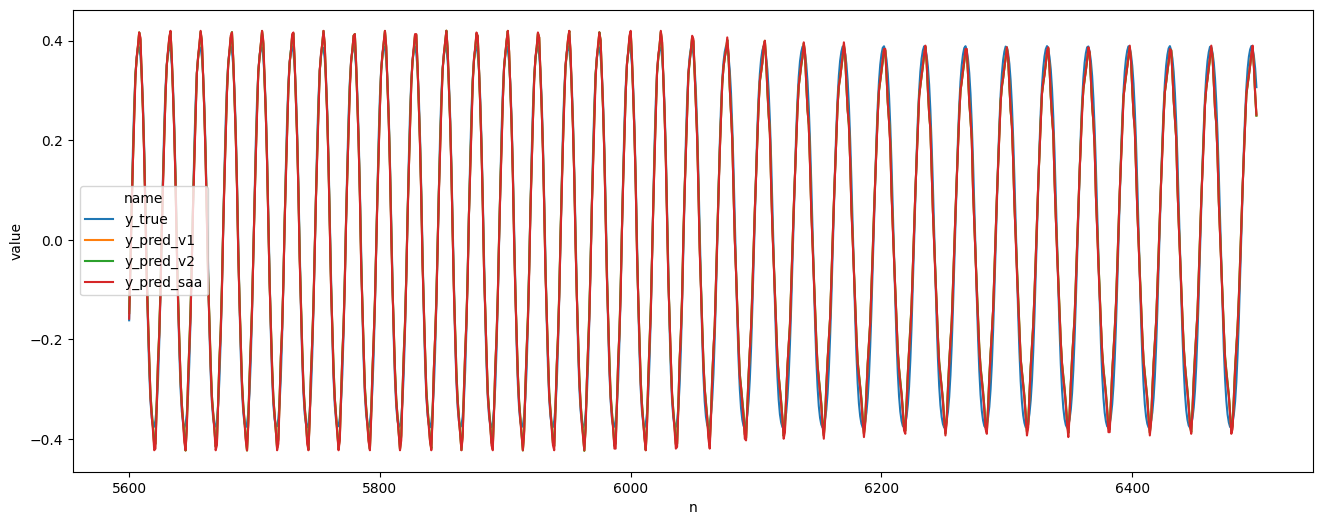

In [75]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=test_df, x='n', y='value', hue='name')

generate assets for deploy
* saved_model, which will need to be zipped
* quantisation_data.npy

In [52]:
test_model_v2.save("/tmp/saved_model")

INFO:tensorflow:Assets written to: /tmp/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/assets


In [65]:
# sample N examples from training data for quantisation 

quantisation_data = []
idxs = list(range(len(train_x)))
random.shuffle(idxs)
for i in idxs[:400]:
    quantisation_data.append(train_x[i:i+TEST_SEQ_LEN])
quantisation_data = np.stack(quantisation_data).astype(np.float32)
print("quantisation_data", quantisation_data.shape)
np.save("/tmp/quantisation_data.npy", quantisation_data)

quantisation_data (400, 9, 2)


also generate some test features for checking inference

In [71]:
with open("/tmp/test_features.txt", "w") as f:
    for feature in test_x.flatten():
        #print(feature)
        print(feature, file=f)

# now deploy to EI

and run inference to collect results from above test_features.txt

`./build/app > /tmp/y_pred.stand_alone_app.txt`

and reread back in to ply vs y_true

<Axes: xlabel='n', ylabel='value'>

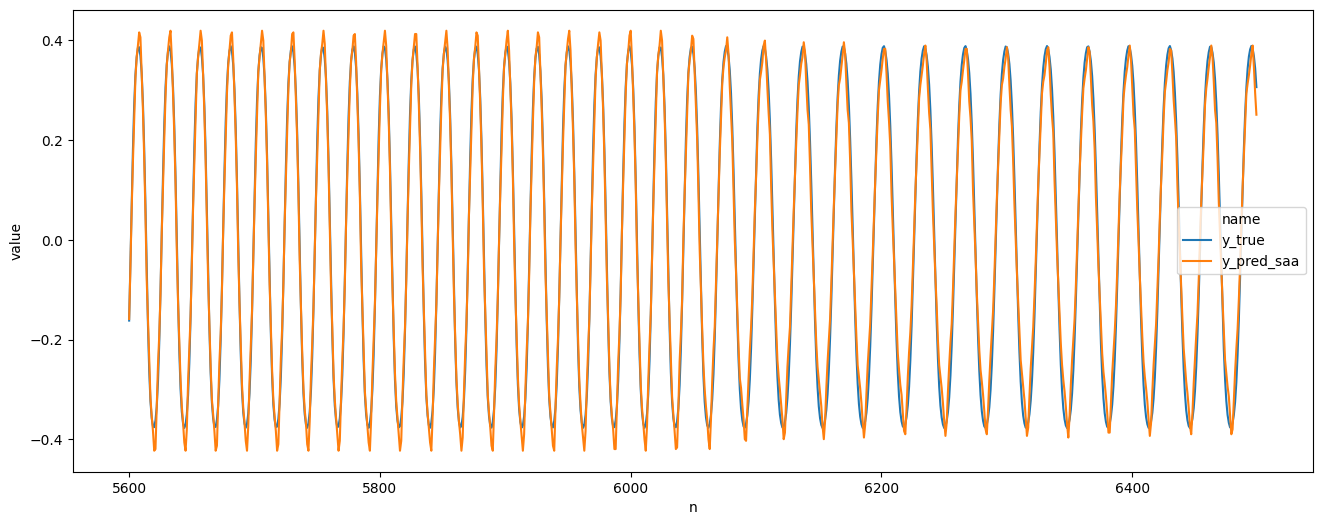

In [79]:
y_pred_stand_alone_app = list(map(float, open('/tmp/y_pred.stand_alone_app.txt').readlines()))

test_records = []
for i in range(5600, 6500):
    y_true = float(test_y[i+TEST_SEQ_LEN])
    test_records.append((i, 'y_true', y_true))
    test_records.append((i, 'y_pred_saa', y_pred_stand_alone_app[i]))    
test_df = pd.DataFrame(test_records, columns=['n', 'name', 'value'])

plt.figure(figsize=(16, 6))
sns.lineplot(data=test_df, x='n', y='value', hue='name')